In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/train.csv',index_col="tripid")

In [4]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


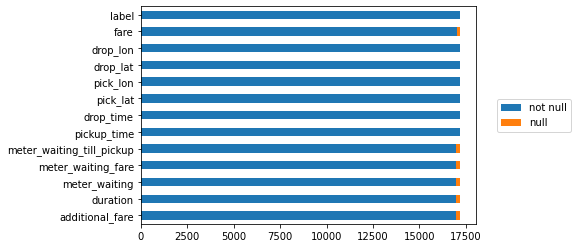

In [5]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

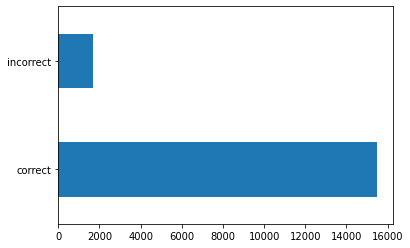

In [6]:
train_df['label'].value_counts().plot.barh()

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

In [0]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [0]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [0]:
labels_df = preprocess_labels(labels_raw_df)

In [0]:
def preprocess_features(input_features_df):
  features_df = input_features_df.copy()
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = KNNImputer()
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [12]:
features_df = preprocess_features(features_raw_df)
features_df.shape

(17176, 32)

In [0]:
test_features_raw_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [0]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [0]:
import tensorflow as tf
tf.compat.v1.set_random_seed(RANDOM_SEED)
from tensorflow import keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
pip install scikit-optimize

     |████████████████████████████████| 81kB 1.7MB/s 


In [0]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  

In [0]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_input_nodes = Integer(low=1, high=20, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=28, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')
dim_batch_size = Integer(low=1, high=64, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay
             ]
default_parameters = [1e-3, 1,20, 13, 'relu',1, 1e-3]

In [0]:
def create_model(learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, adam_decay):
    #start the model making process and create our first layer
    model = keras.Sequential([keras.layers.Flatten(input_shape=(x_train.shape[1],))])
    model.add(keras.layers.Dense(num_input_nodes, activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(keras.layers.Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(keras.layers.Dense(1,activation='softmax'))
    
    #setup our optimizer and compile
    adam = keras.optimizers.Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                 metrics=[f1, "accuracy"])
    return model

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, 
            num_dense_nodes,activation, batch_size,adam_decay):

    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay
                        )
    

    #named blackbox becuase it represents the structure
    blackbox = model.fit(x=x_train,
                        y=y_train,
                        epochs=3,
                        batch_size=batch_size,
                        validation_split=0.15,
                        )
    #return the validation accuracy for the last epoch.
    f1_score = blackbox.history['val_f1'][-1]

    # Print the classification accuracy.
    print()
    print(f"F1 Score: {f1_score}")
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -f1_score

In [0]:
input_shape = x_train.shape[1]

gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=100,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)

In [31]:
model = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[5])
model.fit(x_train,y_train, epochs=3)
model.evaluate(x_eval,y_eval)

Epoch 1/3
430/430 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - f1: 0.9478 - accuracy: 0.9021
Epoch 2/3
430/430 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - f1: 0.9478 - accuracy: 0.9021
Epoch 3/3
108/108 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - f1: 0.9479 - accuracy: 0.9022


[0.0, 0.947860062122345, 0.9022118449211121]

In [33]:
y_pred = model.predict(x_eval)
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [0]:
K.clear_session()
tf.compat.v1.reset_default_graph()

In [35]:
gp_result.x

[0.01, 1, 20, 28, 'relu', 64, 0.01]

In [0]:
learning_rate,
num_dense_layers=num_dense_layers,
num_input_nodes=num_input_nodes,
num_dense_nodes=num_dense_nodes,
activation=activation,
adam_decay=adam_decay
[0.0003914678978787574, 2, 20, 27, 'relu', 64, 0.007950226907685586]
[0.01, 1, 20, 28, 'relu', 64, 0.01]

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    keras.layers.Dense(28, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
	  keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dropout(0.12),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [0]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, decay= 0.007),
              loss='binary_crossentropy',
              metrics=[f1])


In [47]:
model.fit(x_train, y_train.values.ravel(), epochs=50, batch_size=1)

Epoch 1/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.3890 - f1: 0.8910
Epoch 2/50
13740/13740 [==============================] - 18s 1ms/step - loss: 0.3860 - f1: 0.8916
Epoch 3/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.4016 - f1: 0.8924
Epoch 4/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.3968 - f1: 0.8908
Epoch 5/50
13740/13740 [==============================] - 20s 1ms/step - loss: 0.3913 - f1: 0.8924
Epoch 6/50
13740/13740 [==============================] - 18s 1ms/step - loss: 0.3969 - f1: 0.8921
Epoch 7/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.4003 - f1: 0.8929
Epoch 8/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.3891 - f1: 0.8916
Epoch 9/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.3783 - f1: 0.8908
Epoch 10/50
13740/13740 [==============================] - 17s 1ms/step - loss: 0.3896 - f1: 0.8921
Epoch 11/

In [0]:
y_pred = model.predict(x_eval)

In [49]:
y_pred

array([[0.894089  ],
       [0.87049526],
       [0.91166043],
       ...,
       [0.938635  ],
       [0.86223626],
       [0.91708434]], dtype=float32)

In [0]:
thresh = 0.5
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh] = 0

In [56]:
from sklearn.metrics import f1_score

print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.949111
F1 score macro: 0.497544


In [0]:
test_pred = model.predict(test_features_df)

thresh = 0.5
test_pred[test_pred >= thresh] = 1
test_pred[test_pred < thresh] = 0

submission_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/sample_submission.csv',index_col="tripid")

np.testing.assert_array_equal(test_features_df.index.values, 
                          submission_df.index.values)

submission_df["prediction"] = test_pred
submission_df['prediction'] = submission_df['prediction'].astype(int)

submission_df.to_csv('/content/drive/My Drive/Semester 7/Machine Learning/submission_6.csv', index=True)